In [6]:
import requests
import pandas as pd

# Get historical Fear and Greed Index data from alternative.me
url = 'https://api.alternative.me/fng/?limit=1000&format=json'
response = requests.get(url)
data = response.json()

# Convert the data to a DataFrame
fng_data = pd.DataFrame(data['data'])
fng_data['timestamp'] = pd.to_datetime(fng_data['timestamp'], unit='s')  # Convert to readable date
fng_data['value'] = fng_data['value'].astype(int)  # Convert value to integer

# Display the first few rows of the Fear and Greed data
print(fng_data.head())


   value value_classification  timestamp time_until_update
0     72                Greed 2024-10-19             72667
1     73                Greed 2024-10-18               NaN
2     71                Greed 2024-10-17               NaN
3     73                Greed 2024-10-16               NaN
4     65                Greed 2024-10-15               NaN


/tmp/ipykernel_84509/4222383298.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  fng_data['timestamp'] = pd.to_datetime(fng_data['timestamp'], unit='s')  # Convert to readable date


In [7]:
from binance.client import Client
import pandas as pd

# Initialize Binance API (no need for API key if you're just pulling historical data)
client = Client()

# Fetch historical BTCUSDT prices (daily)
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2020", "1 Jan, 2024")

# Convert the data to a DataFrame
btc_data = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 
                                         'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
                                         'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to readable date and close to float
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'], unit='ms')
btc_data['close'] = btc_data['close'].astype(float)

# Keep only the date and closing price columns
btc_data = btc_data[['timestamp', 'close']]

# Display the first few rows of the BTC data
print(btc_data.head())


   timestamp    close
0 2020-01-01  7200.85
1 2020-01-02  6965.71
2 2020-01-03  7344.96
3 2020-01-04  7354.11
4 2020-01-05  7358.75


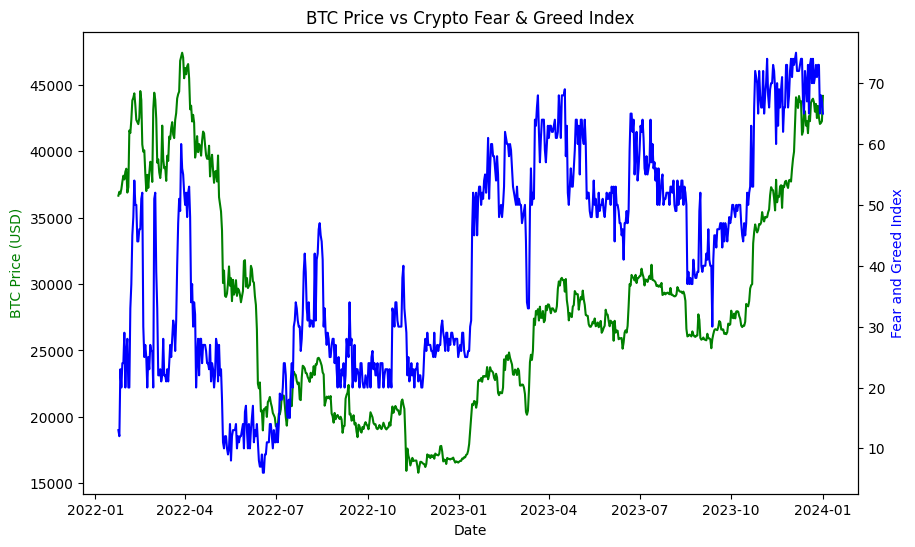

In [8]:
import matplotlib.pyplot as plt

# Merge Fear and Greed Index and BTC price data on the timestamp
merged_data = pd.merge(fng_data[['timestamp', 'value']], btc_data, on='timestamp', how='inner')

# Plot the Fear and Greed Index and BTC price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Fear and Greed Index (on a secondary Y-axis)
ax2 = ax1.twinx()
ax1.plot(merged_data['timestamp'], merged_data['close'], 'g-', label='BTC Price')
ax2.plot(merged_data['timestamp'], merged_data['value'], 'b-', label='Fear & Greed Index')

# Set labels and legends
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color='g')
ax2.set_ylabel('Fear and Greed Index', color='b')

plt.title('BTC Price vs Crypto Fear & Greed Index')
plt.show()


In [9]:
merged_data

,timestamp,value,close
0,2024-01-01,65,44179.55
1,2023-12-31,67,42283.58
2,2023-12-30,68,42140.28
3,2023-12-29,65,42066.95
4,2023-12-28,73,42563.76
...,...,...,...
703,2022-01-28,24,37716.56
704,2022-01-27,20,37160.10
705,2022-01-26,23,36809.34
706,2022-01-25,12,36958.32


In [11]:
merged_data.rename(columns={'value': 'fear_greed_index'}, inplace=True)
merged_data.rename(columns={'close': 'btc_price'}, inplace=True)



Correlation between standardized Fear & Greed Index and BTC Price: 0.3837


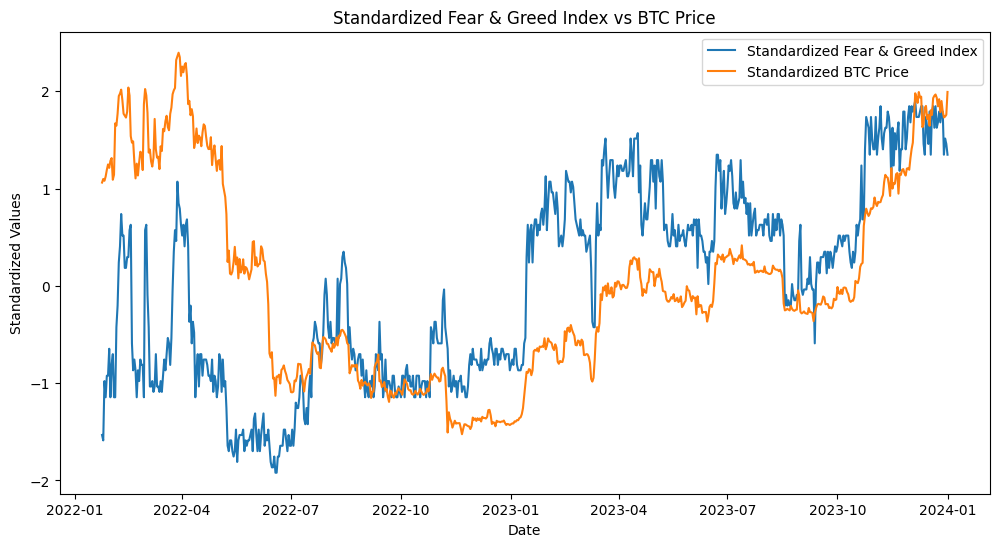

In [12]:
# Standardize the fear_greed_index and btc_price columns
merged_data['fear_greed_index_std'] = (merged_data['fear_greed_index'] - merged_data['fear_greed_index'].mean()) / merged_data['fear_greed_index'].std()
merged_data['btc_price_std'] = (merged_data['btc_price'] - merged_data['btc_price'].mean()) / merged_data['btc_price'].std()

# Calculate the correlation between standardized fear_greed_index and btc_price
correlation = merged_data['fear_greed_index_std'].corr(merged_data['btc_price_std'])

print(f"Correlation between standardized Fear & Greed Index and BTC Price: {correlation:.4f}")

# Visualize the standardized data
plt.figure(figsize=(12, 6))
plt.plot(merged_data['timestamp'], merged_data['fear_greed_index_std'], label='Standardized Fear & Greed Index')
plt.plot(merged_data['timestamp'], merged_data['btc_price_std'], label='Standardized BTC Price')
plt.xlabel('Date')
plt.ylabel('Standardized Values')
plt.title('Standardized Fear & Greed Index vs BTC Price')
plt.legend()
plt.show()


In [13]:
greed_fear_index = merged_data[['timestamp', 'fear_greed_index', 'btc_price']]

# Calculate percentage change for fear_greed_index and btc_price
greed_fear_index['fear_greed_index_pct_change'] = greed_fear_index['fear_greed_index'].pct_change() * 100
greed_fear_index['btc_price_pct_change'] = greed_fear_index['btc_price'].pct_change() * 100

# Sort the dataframe by timestamp in descending order to get the most recent data first
greed_fear_index = greed_fear_index.sort_values('timestamp', ascending=False)

# Display the first few rows of the updated dataframe
print(greed_fear_index.head())

# Calculate the average percentage changes
avg_fear_greed_change = greed_fear_index['fear_greed_index_pct_change'].mean()
avg_btc_price_change = greed_fear_index['btc_price_pct_change'].mean()

print(f"\nAverage daily percentage change in Fear & Greed Index: {avg_fear_greed_change:.2f}%")
print(f"Average daily percentage change in BTC Price: {avg_btc_price_change:.2f}%")



   timestamp  fear_greed_index  btc_price  fear_greed_index_pct_change  \
0 2024-01-01                65   44179.55                          NaN   
1 2023-12-31                67   42283.58                     3.076923   
2 2023-12-30                68   42140.28                     1.492537   
3 2023-12-29                65   42066.95                    -4.411765   
4 2023-12-28                73   42563.76                    12.307692   

   btc_price_pct_change  
0                   NaN  
1             -4.291510  
2             -0.338902  
3             -0.174014  
4              1.180998  

Average daily percentage change in Fear & Greed Index: 0.69%
Average daily percentage change in BTC Price: 0.02%


/tmp/ipykernel_84509/1262720666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greed_fear_index['fear_greed_index_pct_change'] = greed_fear_index['fear_greed_index'].pct_change() * 100


Correlation between standardized Fear & Greed Index % change and BTC Price % change: 0.0119


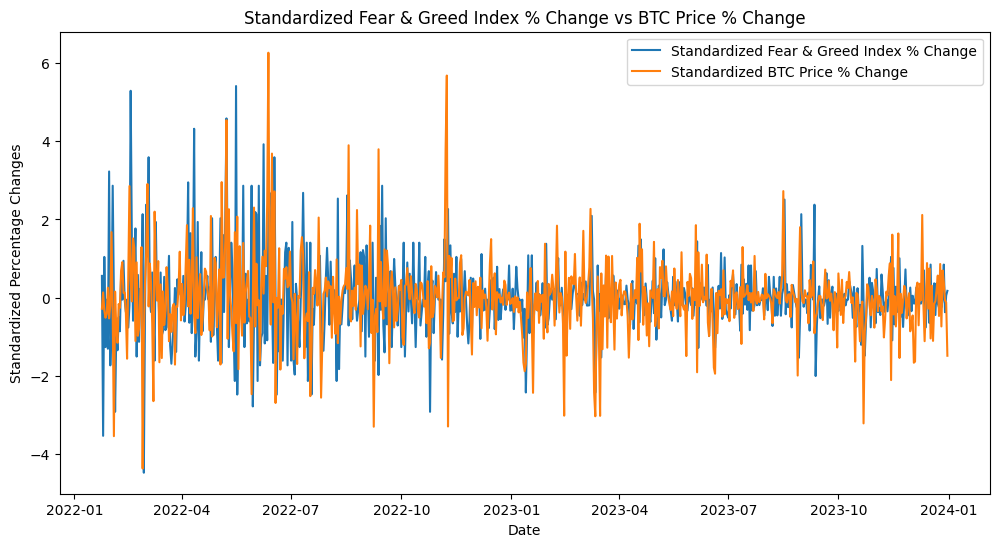

In [15]:
# Standardize the percentage change columns
greed_fear_index['fear_greed_index_pct_change_std'] = (greed_fear_index['fear_greed_index_pct_change'] - greed_fear_index['fear_greed_index_pct_change'].mean()) / greed_fear_index['fear_greed_index_pct_change'].std()
greed_fear_index['btc_price_pct_change_std'] = (greed_fear_index['btc_price_pct_change'] - greed_fear_index['btc_price_pct_change'].mean()) / greed_fear_index['btc_price_pct_change'].std()

# Calculate the correlation between standardized percentage changes
correlation_pct_change = greed_fear_index['fear_greed_index_pct_change_std'].corr(greed_fear_index['btc_price_pct_change_std'])

print(f"Correlation between standardized Fear & Greed Index % change and BTC Price % change: {correlation_pct_change:.4f}")

# Visualize the standardized percentage changes
plt.figure(figsize=(12, 6))
plt.plot(greed_fear_index['timestamp'], greed_fear_index['fear_greed_index_pct_change_std'], label='Standardized Fear & Greed Index % Change')
plt.plot(greed_fear_index['timestamp'], greed_fear_index['btc_price_pct_change_std'], label='Standardized BTC Price % Change')
plt.xlabel('Date')
plt.ylabel('Standardized Percentage Changes')
plt.title('Standardized Fear & Greed Index % Change vs BTC Price % Change')
plt.legend()
plt.show()
